# Loading_Data + Train/Dev Split + Data Augmentation

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
from skimage import io
from matplotlib.pyplot import imread, imshow, subplots, show
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import gc
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


In [ ]:
#Loading data function
def image_loader(folder_path,X,y,label):
  for filename in os.listdir(folder_path):
      if filename.endswith(".jpeg") or filename.endswith(".png"):
          img = io.imread(os.path.join(folder_path, filename), as_gray=False)
          X.append(img)
          y.append(label)

In [ ]:
y_img = []
X_img = []
##Load Hurricane Damaged Image
folder_path = "/content/drive/MyDrive/Hurricane_Damage_Satellite/train_dev/damage"
label = 1
image_loader(folder_path, X_img, y_img, label)

In [ ]:
##Load Hurricane unDamaged Image
folder_path = "/content/drive/MyDrive/Hurricane_Damage_Satellite/train_dev/no_damage"
label = 0
image_loader(folder_path, X_img, y_img, label)

In [ ]:
##Data Augmentation function
def image_rotator(folder_path,X,y,label):
  for filename in os.listdir(folder_path):
      if filename.endswith(".jpeg") or filename.endswith(".png"):
          img = io.imread(os.path.join(folder_path, filename), as_gray=False)
          data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')
          images = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
          data_generator.fit(images)
          img_r = data_generator.flow(images).next()[0]

          X.append(img_r)
          y.append(label)

In [ ]:
##Load rotated Hurricane unDamaged Image
folder_path = "/content/drive/MyDrive/Hurricane_Damage_Satellite/train_dev/no_damage"
label = 0
image_rotator(folder_path, X_img, y_img, label)

In [ ]:
##Load rotated misclassified Image
folder_path = "/content/drive/My Drive/Hurricane_Damage_Satellite/Augumentation/damage"
label = 1
image_rotator(folder_path, X_img, y_img, label)
folder_path = "/content/drive/My Drive/Hurricane_Damage_Satellite/Augumentation/no_damage"
label = 0
image_rotator(folder_path, X_img, y_img, label)

In [ ]:
#Make X and y np array
X = np.array(X_img)
y = np.array(y_img)

In [ ]:
X.shape

(28298, 128, 128, 3)

In [ ]:
#Train/Dev Split stratified on class labels
from sklearn.model_selection import train_test_split
X_tr, X_dev, y_tr, y_dev = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Check shape
X_tr.shape

(22638, 128, 128, 3)

In [ ]:
#Load Test Set dmage
y_te = []
X_te = []
label = 1
folder_path = "/content/drive/MyDrive/Hurricane_Damage_Satellite/test/damage"
image_loader(folder_path, X_te, y_te, label)

In [ ]:
#Load Test Set no_dmage
label = 0
folder_path = "/content/drive/MyDrive/Hurricane_Damage_Satellite/test/no_damage"
image_loader(folder_path, X_te, y_te, label)

X_te = np.array(X_te)
y_te = np.array(y_te)

In [ ]:
y[y==0].shape

(14121,)

# CNN model tuning

In [ ]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [ ]:
def AlexNet():
  # Define the input shape
  input_shape = (128, 128, 3)

  # Create a Sequential model
  model = Sequential()

  # Block 1
  model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Block 2
  model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Block 3
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
  model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

  # Dense layers
  model.add(Flatten())
  model.add(Dense(units=4096, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=4096, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units = 2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.2)))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.5),
              metrics=['accuracy'])

  return model

In [ ]:
# Convert class vectors to 10 class matrices
y_train = keras.utils.np_utils.to_categorical(y_tr, 2)
y_val = keras.utils.np_utils.to_categorical(y_dev, 2)
y_test = keras.utils.np_utils.to_categorical(y_te, 2)


# Create a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model using full batch
np.random.seed(42)
model = AlexNet()
model.fit(X_tr, y_train,
          epochs = 70,
          verbose=1,
          validation_data=(X_dev, y_val), 
          callbacks=[reduce_lr])
# Test accuracy after 30 epochs
score = model.evaluate(X_te, y_test, verbose=0)
print('Test accuracy:', score[1])

Epoch 1/70
708/708 [==============================] - 32s 26ms/step - loss: 28.7958 - accuracy: 0.6099 - val_loss: 0.7331 - val_accuracy: 0.5829 - lr: 0.5000
Epoch 2/70
708/708 [==============================] - 16s 22ms/step - loss: 0.5156 - accuracy: 0.7899 - val_loss: 0.3712 - val_accuracy: 0.8797 - lr: 0.5000
Epoch 3/70
708/708 [==============================] - 16s 22ms/step - loss: 0.3987 - accuracy: 0.8585 - val_loss: 0.3154 - val_accuracy: 0.8951 - lr: 0.5000
Epoch 4/70
708/708 [==============================] - 16s 22ms/step - loss: 0.3447 - accuracy: 0.8821 - val_loss: 0.2956 - val_accuracy: 0.8947 - lr: 0.5000
Epoch 5/70
708/708 [==============================] - 16s 22ms/step - loss: 0.3095 - accuracy: 0.8954 - val_loss: 0.2773 - val_accuracy: 0.9072 - lr: 0.5000
Epoch 6/70
708/708 [==============================] - 16s 22ms/step - loss: 0.2793 - accuracy: 0.9088 - val_loss: 0.3193 - val_accuracy: 0.8892 - lr: 0.5000
Epoch 7/70
708/708 [==============================] - 16s

In [ ]:
## model = load_model('/content/drive/MyDrive/Models/650CNN_10.h5')
# Dev Set CM
pred_dev_CNN = np.argmax(model.predict(X_dev),axis=1)
cm_CNN = confusion_matrix(pred_dev_CNN, y_dev)
print(cm_CNN)

177/177 [==============================] - 1s 7ms/step
[[2676  182]
 [ 148 2654]]


In [ ]:
# Test Set CM
pred_te_CNN = np.argmax(model.predict(X_te),axis=1)
cm_CNN = confusion_matrix(pred_te_CNN, y_te)
print(cm_CNN)

63/63 [==============================] - 1s 7ms/step
[[984  15]
 [ 16 985]]


In [ ]:
# Assuming `model` is your trained TensorFlow model
model.save('/content/drive/MyDrive/Models/650CNN_11.h5')

In [ ]:
idx = np.where(pred_dev_CNN!=y_dev)

actual: 1
predict: 0


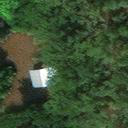

actual: 0
predict: 1


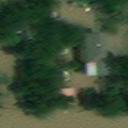

actual: 0
predict: 1


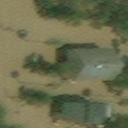

actual: 0
predict: 1


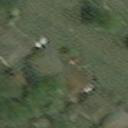

actual: 0
predict: 1


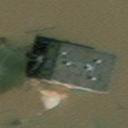

actual: 0
predict: 1


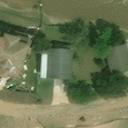

actual: 1
predict: 0


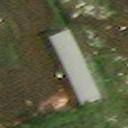

actual: 1
predict: 0


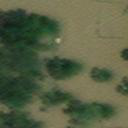

actual: 0
predict: 1


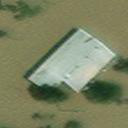

actual: 0
predict: 1


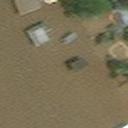

actual: 1
predict: 0


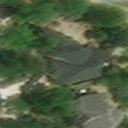

actual: 0
predict: 1


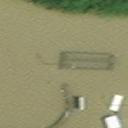

actual: 0
predict: 1


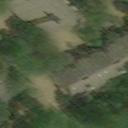

actual: 1
predict: 0


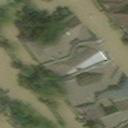

actual: 0
predict: 1


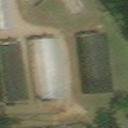

actual: 0
predict: 1


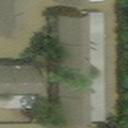

actual: 1
predict: 0


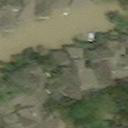

actual: 0
predict: 1


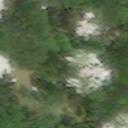

actual: 0
predict: 1


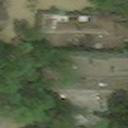

actual: 0
predict: 1


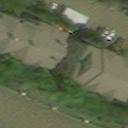

actual: 1
predict: 0


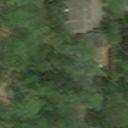

actual: 1
predict: 0


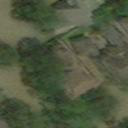

actual: 0
predict: 1


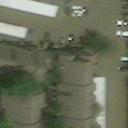

actual: 1
predict: 0


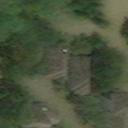

actual: 1
predict: 0


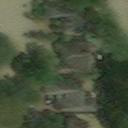

actual: 1
predict: 0


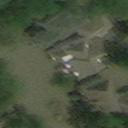

actual: 1
predict: 0


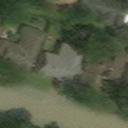

actual: 0
predict: 1


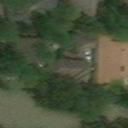

actual: 1
predict: 0


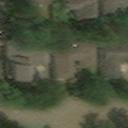

actual: 0
predict: 1


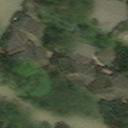

actual: 1
predict: 0


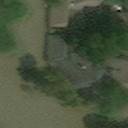

actual: 0
predict: 1


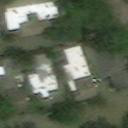

actual: 1
predict: 0


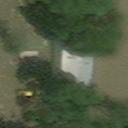

actual: 0
predict: 1


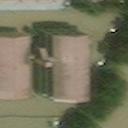

actual: 1
predict: 0


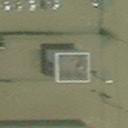

actual: 1
predict: 0


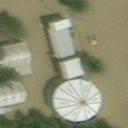

actual: 0
predict: 1


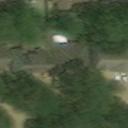

actual: 0
predict: 1


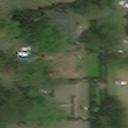

actual: 1
predict: 0


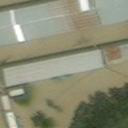

actual: 0
predict: 1


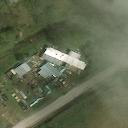

actual: 0
predict: 1


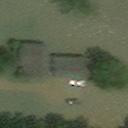

actual: 0
predict: 1


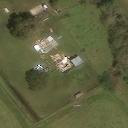

actual: 0
predict: 1


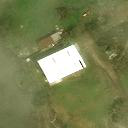

actual: 0
predict: 1


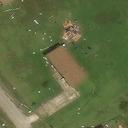

actual: 0
predict: 1


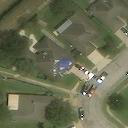

actual: 1
predict: 0


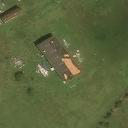

actual: 0
predict: 1


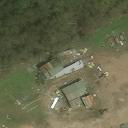

actual: 1
predict: 0


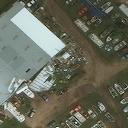

actual: 0
predict: 1


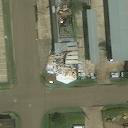

actual: 1
predict: 0


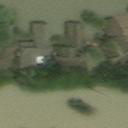

actual: 0
predict: 1


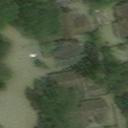

actual: 0
predict: 1


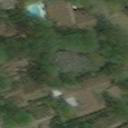

actual: 1
predict: 0


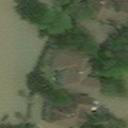

actual: 1
predict: 0


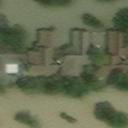

actual: 1
predict: 0


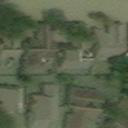

actual: 0
predict: 1


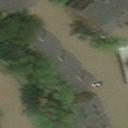

actual: 0
predict: 1


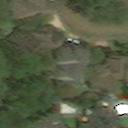

actual: 1
predict: 0


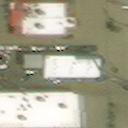

actual: 1
predict: 0


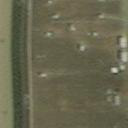

actual: 1
predict: 0


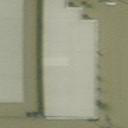

actual: 1
predict: 0


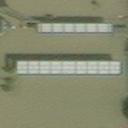

actual: 1
predict: 0


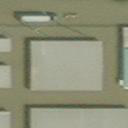

actual: 0
predict: 1


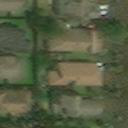

actual: 1
predict: 0


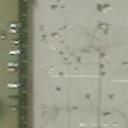

actual: 0
predict: 1


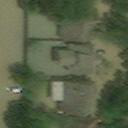

actual: 1
predict: 0


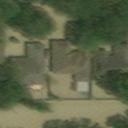

actual: 0
predict: 1


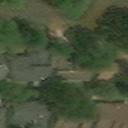

actual: 1
predict: 0


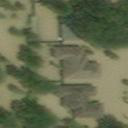

actual: 1
predict: 0


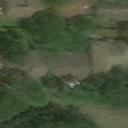

actual: 0
predict: 1


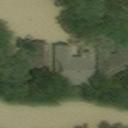

actual: 1
predict: 0


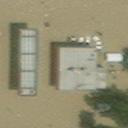

actual: 1
predict: 0


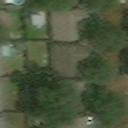

actual: 1
predict: 0


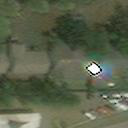

actual: 1
predict: 0


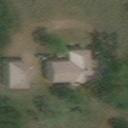

actual: 0
predict: 1


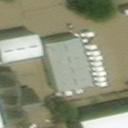

actual: 0
predict: 1


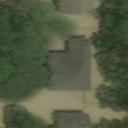

actual: 0
predict: 1


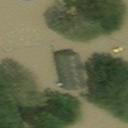

actual: 1
predict: 0


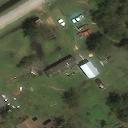

actual: 1
predict: 0


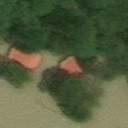

actual: 0
predict: 1


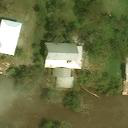

actual: 0
predict: 1


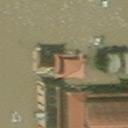

actual: 0
predict: 1


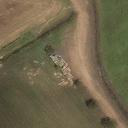

actual: 1
predict: 0


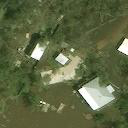

actual: 1
predict: 0


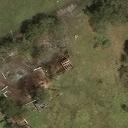

actual: 0
predict: 1


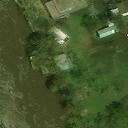

actual: 0
predict: 1


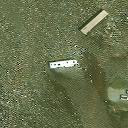

actual: 1
predict: 0


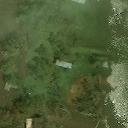

actual: 1
predict: 0


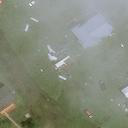

actual: 1
predict: 0


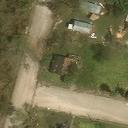

actual: 1
predict: 0


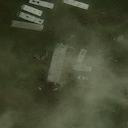

actual: 1
predict: 0


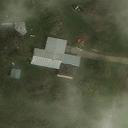

actual: 0
predict: 1


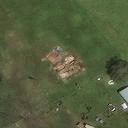

actual: 1
predict: 0


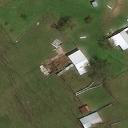

actual: 1
predict: 0


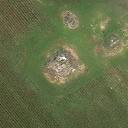

actual: 1
predict: 0


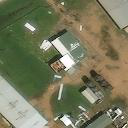

actual: 0
predict: 1


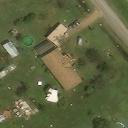

actual: 1
predict: 0


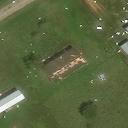

actual: 0
predict: 1


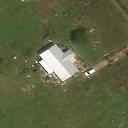

actual: 0
predict: 1


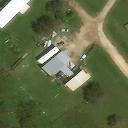

actual: 1
predict: 0


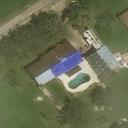

actual: 1
predict: 0


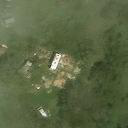

actual: 0
predict: 1


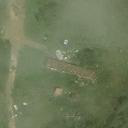

actual: 0
predict: 1


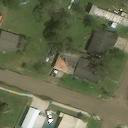

actual: 1
predict: 0


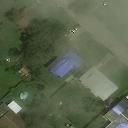

actual: 1
predict: 0


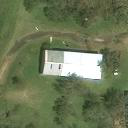

actual: 1
predict: 0


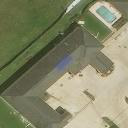

actual: 0
predict: 1


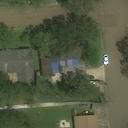

actual: 0
predict: 1


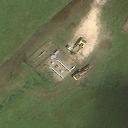

actual: 1
predict: 0


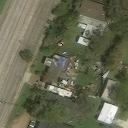

actual: 1
predict: 0


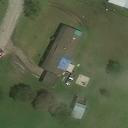

actual: 0
predict: 1


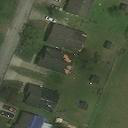

actual: 1
predict: 0


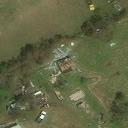

actual: 1
predict: 0


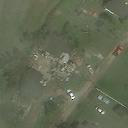

actual: 0
predict: 1


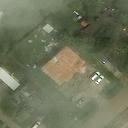

actual: 1
predict: 0


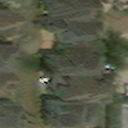

actual: 1
predict: 0


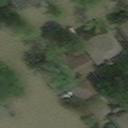

actual: 0
predict: 1


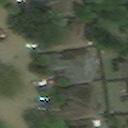

actual: 0
predict: 1


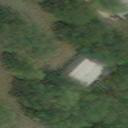

actual: 1
predict: 0


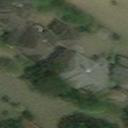

actual: 0
predict: 1


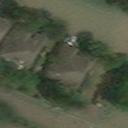

actual: 0
predict: 1


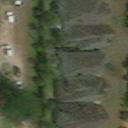

actual: 1
predict: 0


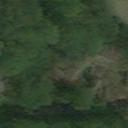

actual: 0
predict: 1


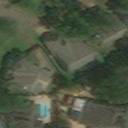

actual: 1
predict: 0


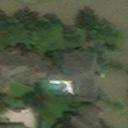

actual: 1
predict: 0


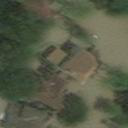

actual: 0
predict: 1


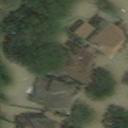

actual: 1
predict: 0


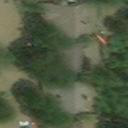

actual: 0
predict: 1


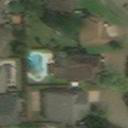

actual: 0
predict: 1


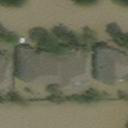

actual: 0
predict: 1


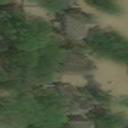

actual: 1
predict: 0


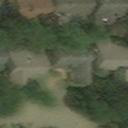

actual: 1
predict: 0


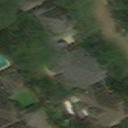

actual: 1
predict: 0


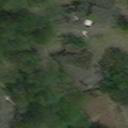

actual: 0
predict: 1


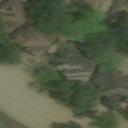

actual: 1
predict: 0


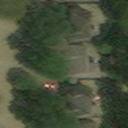

actual: 1
predict: 0


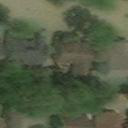

actual: 1
predict: 0


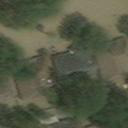

actual: 1
predict: 0


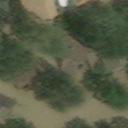

actual: 1
predict: 0


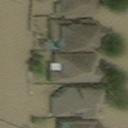

actual: 1
predict: 0


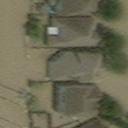

actual: 0
predict: 1


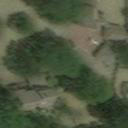

actual: 0
predict: 1


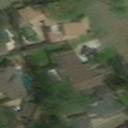

actual: 0
predict: 1


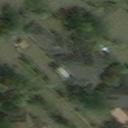

actual: 1
predict: 0


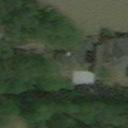

actual: 1
predict: 0


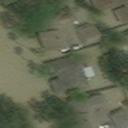

actual: 0
predict: 1


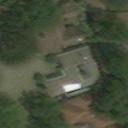

actual: 1
predict: 0


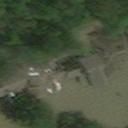

actual: 1
predict: 0


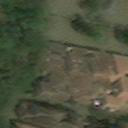

actual: 1
predict: 0


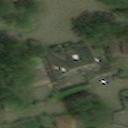

actual: 1
predict: 0


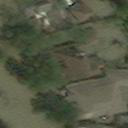

actual: 1
predict: 0


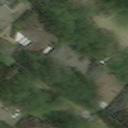

actual: 0
predict: 1


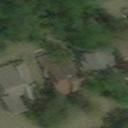

actual: 0
predict: 1


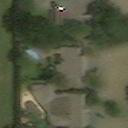

actual: 1
predict: 0


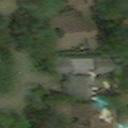

actual: 1
predict: 0


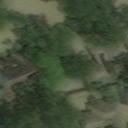

actual: 1
predict: 0


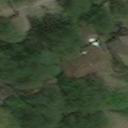

actual: 1
predict: 0


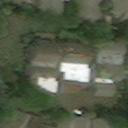

actual: 1
predict: 0


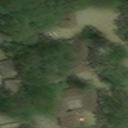

actual: 1
predict: 0


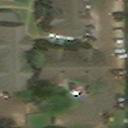

actual: 1
predict: 0


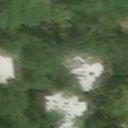

actual: 1
predict: 0


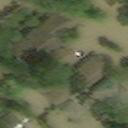

actual: 1
predict: 0


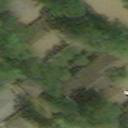

actual: 1
predict: 0


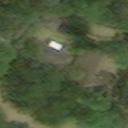

actual: 0
predict: 1


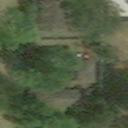

actual: 1
predict: 0


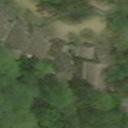

actual: 0
predict: 1


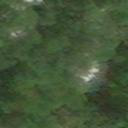

actual: 1
predict: 0


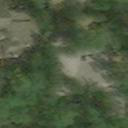

actual: 0
predict: 1


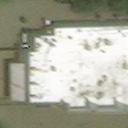

actual: 0
predict: 1


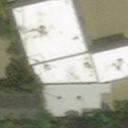

actual: 1
predict: 0


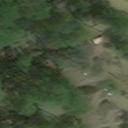

actual: 1
predict: 0


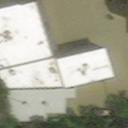

actual: 1
predict: 0


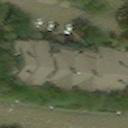

actual: 1
predict: 0


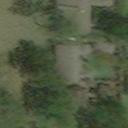

actual: 1
predict: 0


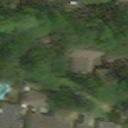

actual: 1
predict: 0


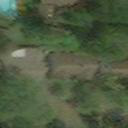

actual: 0
predict: 1


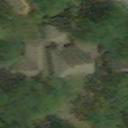

actual: 1
predict: 0


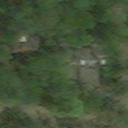

actual: 1
predict: 0


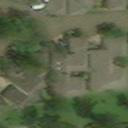

actual: 0
predict: 1


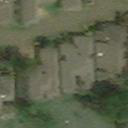

actual: 0
predict: 1


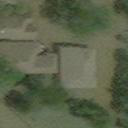

actual: 1
predict: 0


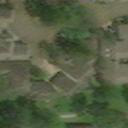

actual: 1
predict: 0


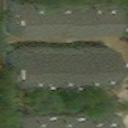

actual: 1
predict: 0


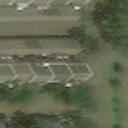

actual: 1
predict: 0


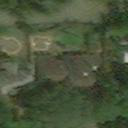

actual: 1
predict: 0


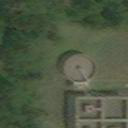

actual: 1
predict: 0


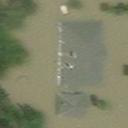

actual: 1
predict: 0


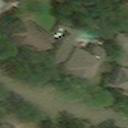

actual: 0
predict: 1


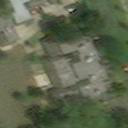

actual: 1
predict: 0


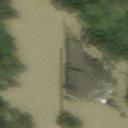

actual: 1
predict: 0


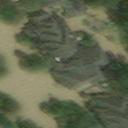

actual: 1
predict: 0


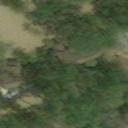

actual: 1
predict: 0


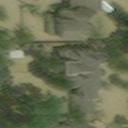

actual: 0
predict: 1


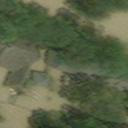

actual: 0
predict: 1


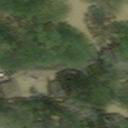

actual: 0
predict: 1


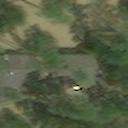

actual: 0
predict: 1


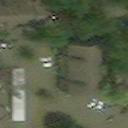

actual: 0
predict: 1


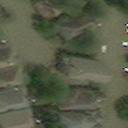

actual: 0
predict: 1


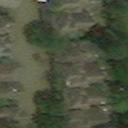

actual: 1
predict: 0


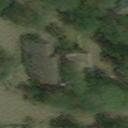

actual: 1
predict: 0


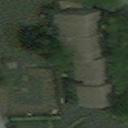

actual: 0
predict: 1


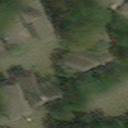

actual: 1
predict: 0


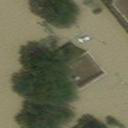

actual: 1
predict: 0


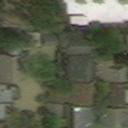

actual: 1
predict: 0


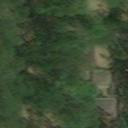

actual: 1
predict: 0


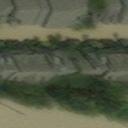

actual: 1
predict: 0


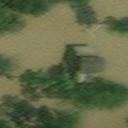

actual: 1
predict: 0


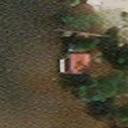

actual: 1
predict: 0


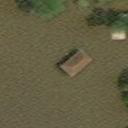

actual: 0
predict: 1


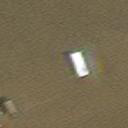

actual: 0
predict: 1


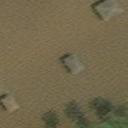

actual: 1
predict: 0


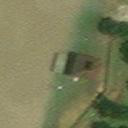

actual: 1
predict: 0


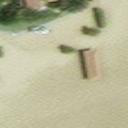

actual: 1
predict: 0


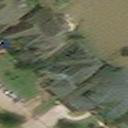

actual: 1
predict: 0


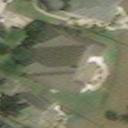

actual: 1
predict: 0


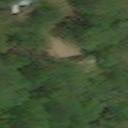

actual: 0
predict: 1


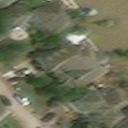

actual: 0
predict: 1


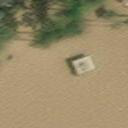

actual: 0
predict: 1


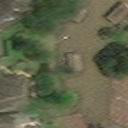

actual: 1
predict: 0


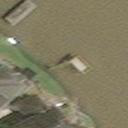

actual: 0
predict: 1


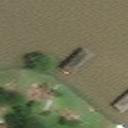

actual: 0
predict: 1


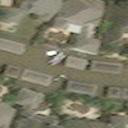

actual: 0
predict: 1


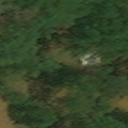

actual: 1
predict: 0


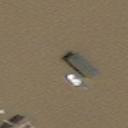

actual: 0
predict: 1


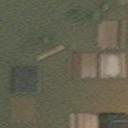

actual: 0
predict: 1


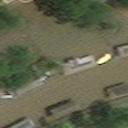

actual: 1
predict: 0


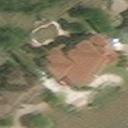

actual: 1
predict: 0


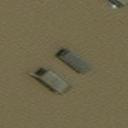

actual: 1
predict: 0


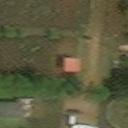

actual: 1
predict: 0


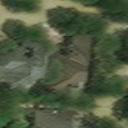

actual: 1
predict: 0


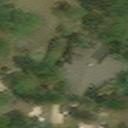

actual: 1
predict: 0


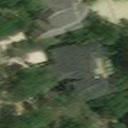

actual: 0
predict: 1


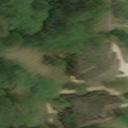

actual: 1
predict: 0


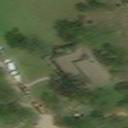

actual: 1
predict: 0


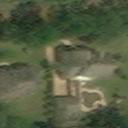

actual: 1
predict: 0


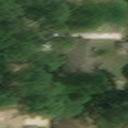

actual: 0
predict: 1


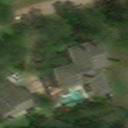

actual: 0
predict: 1


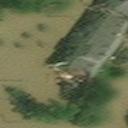

actual: 1
predict: 0


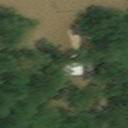

actual: 1
predict: 0


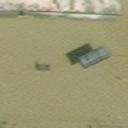

actual: 1
predict: 0


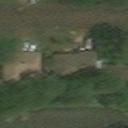

actual: 1
predict: 0


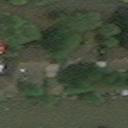

actual: 0
predict: 1


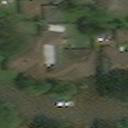

actual: 1
predict: 0


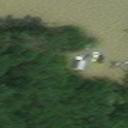

actual: 1
predict: 0


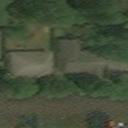

actual: 1
predict: 0


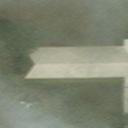

actual: 1
predict: 0


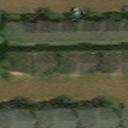

actual: 0
predict: 1


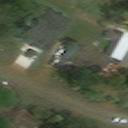

actual: 1
predict: 0


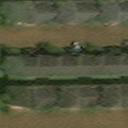

actual: 1
predict: 0


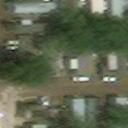

actual: 1
predict: 0


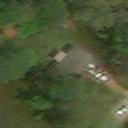

actual: 1
predict: 0


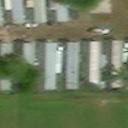

actual: 1
predict: 0


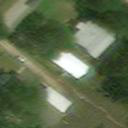

actual: 0
predict: 1


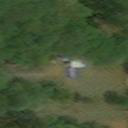

actual: 1
predict: 0


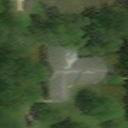

actual: 0
predict: 1


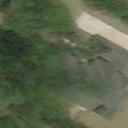

actual: 0
predict: 1


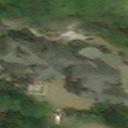

actual: 1
predict: 0


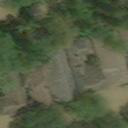

actual: 0
predict: 1


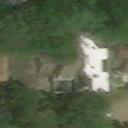

actual: 1
predict: 0


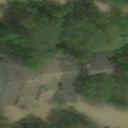

actual: 1
predict: 0


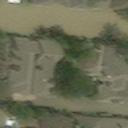

actual: 0
predict: 1


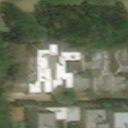

actual: 1
predict: 0


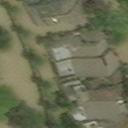

actual: 1
predict: 0


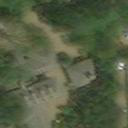

actual: 1
predict: 0


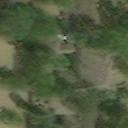

actual: 1
predict: 0


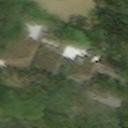

actual: 1
predict: 0


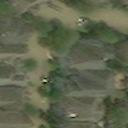

actual: 1
predict: 0


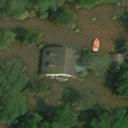

actual: 0
predict: 1


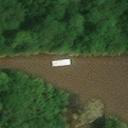

actual: 1
predict: 0


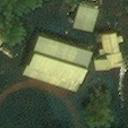

actual: 0
predict: 1


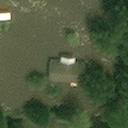

actual: 0
predict: 1


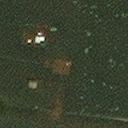

actual: 1
predict: 0


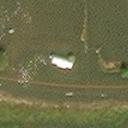

actual: 0
predict: 1


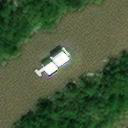

actual: 0
predict: 1


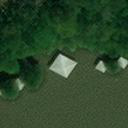

actual: 0
predict: 1


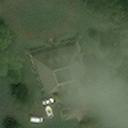

actual: 0
predict: 1


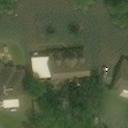

actual: 1
predict: 0


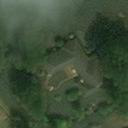

actual: 0
predict: 1


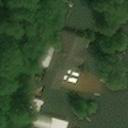

actual: 1
predict: 0


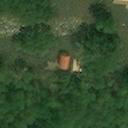

actual: 0
predict: 1


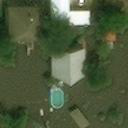

actual: 1
predict: 0


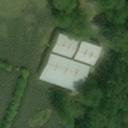

actual: 1
predict: 0


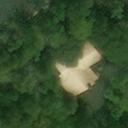

actual: 0
predict: 1


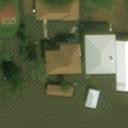

actual: 1
predict: 0


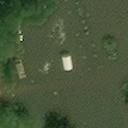

actual: 0
predict: 1


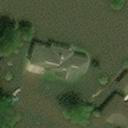

actual: 1
predict: 0


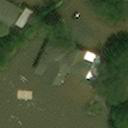

actual: 0
predict: 1


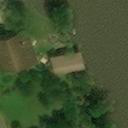

actual: 0
predict: 1


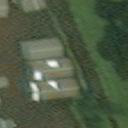

actual: 1
predict: 0


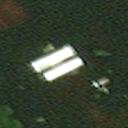

actual: 1
predict: 0


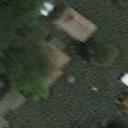

actual: 0
predict: 1


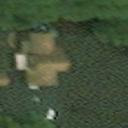

actual: 0
predict: 1


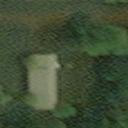

actual: 1
predict: 0


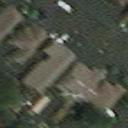

actual: 1
predict: 0


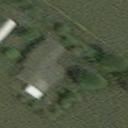

actual: 1
predict: 0


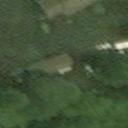

actual: 1
predict: 0


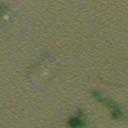

actual: 1
predict: 0


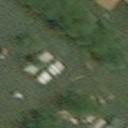

actual: 1
predict: 0


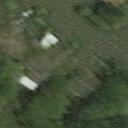

In [ ]:
for i in idx[0]:
  print("actual:", y_dev[i])
  print("predict:", pred_dev_CNN[i])
  img = Image.fromarray(X_img[i])
  file_name = 'img' + str(i) + '.png'
  if y_dev[i] == 1:
    img.save('/content/drive/My Drive/Hurricane_Damage_Satellite/Augumentation/damage/' + file_name)
  else:
    img.save('/content/drive/My Drive/Hurricane_Damage_Satellite/Augumentation/no_damage/' + file_name)
  img.show()

In [ ]:
#Ensemble
model1 = load_model('/content/drive/MyDrive/Models/650CNN_1.h5')
model2 = load_model('/content/drive/MyDrive/Models/650CNN_2.h5')
model3 = load_model('/content/drive/MyDrive/Models/650CNN_3.h5')
model4 = load_model('/content/drive/MyDrive/Models/650CNN_4.h5')
model5 = load_model('/content/drive/MyDrive/Models/650CNN_5.h5')
model6 = load_model('/content/drive/MyDrive/Models/650CNN_6.h5')
model7 = load_model('/content/drive/MyDrive/Models/650CNN_7.h5')
model8 = load_model('/content/drive/MyDrive/Models/650CNN_8.h5')
model9 = load_model('/content/drive/MyDrive/Models/650CNN_9.h5')
model10 = load_model('/content/drive/MyDrive/Models/650CNN_10.h5')
model11 = load_model('/content/drive/MyDrive/Models/650CNN_11.h5')


In [ ]:
pred1 = np.argmax(model1.predict(X_dev),axis=1)
pred2 = np.argmax(model2.predict(X_dev),axis=1)
pred3 = np.argmax(model3.predict(X_dev),axis=1)
pred4 = np.argmax(model4.predict(X_dev),axis=1)
pred5 = np.argmax(model5.predict(X_dev),axis=1)
pred6 = np.argmax(model6.predict(X_dev),axis=1)
pred7 = np.argmax(model7.predict(X_dev),axis=1)
pred8 = np.argmax(model8.predict(X_dev),axis=1)
pred9 = np.argmax(model9.predict(X_dev),axis=1)
pred10 = np.argmax(model10.predict(X_dev),axis=1)
pred11 = np.argmax(model11.predict(X_dev),axis=1)

177/177 [==============================] - 1s 7ms/step


In [ ]:
pred = np.round((pred1 + pred2 + pred3 + pred4 + pred5 + pred6 + pred7 + pred8 + pred9 + pred10) / 10)

# Test accuracy after 30 epochs
accuracy = accuracy_score(y_dev, pred)
print('Dev accuracy:', accuracy)

Dev accuracy: 0.9524734982332156


In [ ]:
#On test set
pred1 = np.argmax(model1.predict(X_te),axis=1)
pred2 = np.argmax(model2.predict(X_te),axis=1)
pred3 = np.argmax(model3.predict(X_te),axis=1)
pred4 = np.argmax(model4.predict(X_te),axis=1)
pred5 = np.argmax(model5.predict(X_te),axis=1)
pred6 = np.argmax(model6.predict(X_te),axis=1)
pred7 = np.argmax(model7.predict(X_te),axis=1)
pred8 = np.argmax(model8.predict(X_te),axis=1)
pred9 = np.argmax(model9.predict(X_te),axis=1)
pred10 = np.argmax(model10.predict(X_te),axis=1)
pred11 = np.argmax(model11.predict(X_te),axis=1)

63/63 [==============================] - 0s 5ms/step


In [ ]:
pred = np.round((pred1 + pred2 + pred3 + pred4 + pred5 + pred6 + pred7 + pred8 + pred9 + pred10 + pred11) / 11)

# Test accuracy after 30 epochs
accuracy = accuracy_score(y_te, pred)
print('Test accuracy:', accuracy)

Test accuracy: 0.9865


In [ ]:
# Dev Set CM
cm_CNN = confusion_matrix(pred, y_te)
print(cm_CNN)

[[982   9]
 [ 18 991]]
